Silakan upload file 'social_media_vs_productivity.csv'


Saving social_media_vs_productivity.csv to social_media_vs_productivity.csv
✅ Data berhasil dimuat.

--- Pembersihan Data dan Penanganan Nilai Hilang ---

Data pelatihan: 24000 sampel, Data pengujian: 6000 sampel


/tmp/ipython-input-1-1327938503.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1-1327938503.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

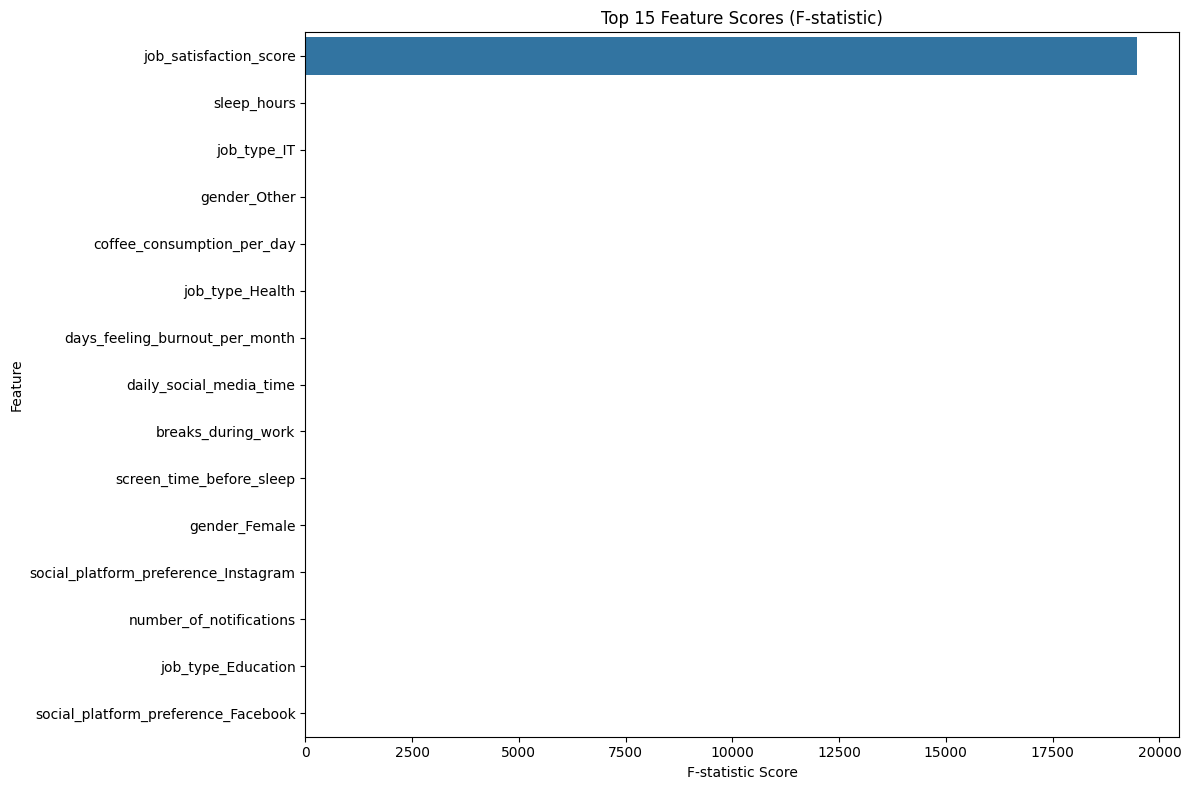


✅ Model berhasil dilatih.

--- Evaluasi ---
Akurasi   : 0.8033
Presisi   : 0.7937
Recall    : 0.8469
F1 Score  : 0.8194
ROC AUC   : 0.8965
Confusion Matrix:
 [[2143  696]
 [ 484 2677]]


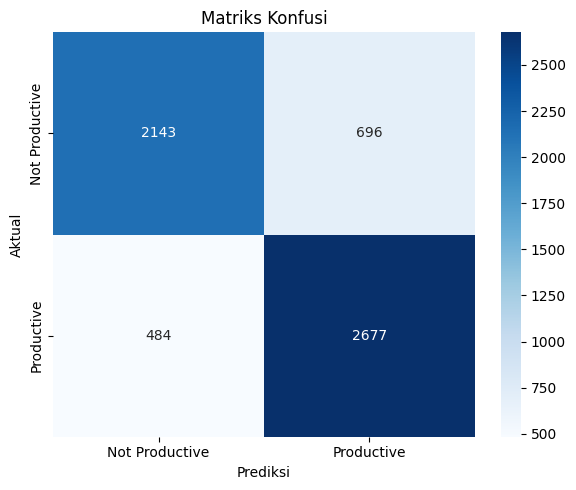


--- Koefisien Fitur Terpilih ---
                          Feature  Coefficient  Abs_Coefficient
6          job_satisfaction_score     2.546004         2.546004
7                    gender_Other    -0.069527         0.069527
1                     sleep_hours    -0.056862         0.056862
8                 job_type_Health    -0.043023         0.043023
4      coffee_consumption_per_day    -0.034405         0.034405
0         daily_social_media_time    -0.021354         0.021354
3              breaks_during_work    -0.019407         0.019407
9                     job_type_IT     0.017261         0.017261
5  days_feeling_burnout_per_month    -0.005744         0.005744
2        screen_time_before_sleep     0.004745         0.004745


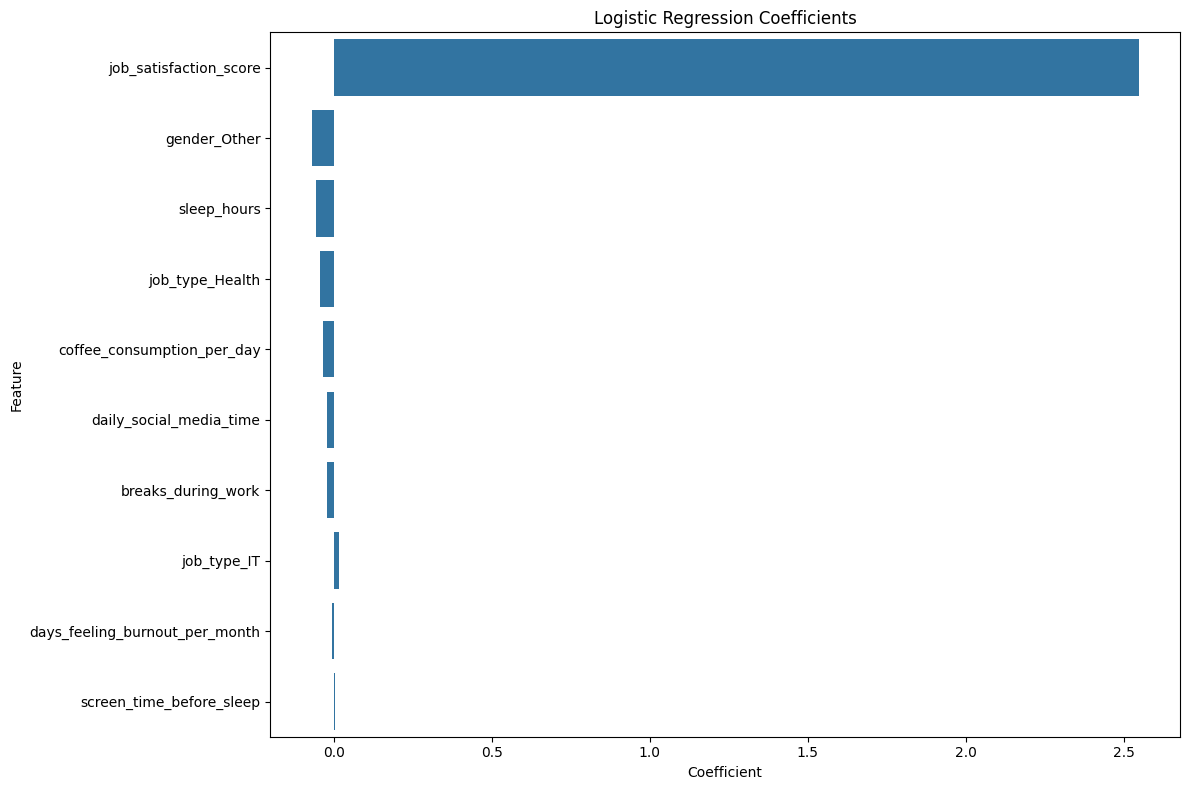


--- Contoh Prediksi Baru ---
Sampel 1: Prob Produktif = 0.9828, Prediksi = Produktif
Sampel 2: Prob Produktif = 0.9420, Prediksi = Produktif
Sampel 3: Prob Produktif = 0.2518, Prediksi = Tidak Produktif


In [ ]:
# --- [1] Upload File CSV ke Google Colab ---
from google.colab import files
import os

print("Silakan upload file 'social_media_vs_productivity.csv'")
uploaded = files.upload()  # Klik tombol untuk unggah

# Membuat folder MultipleFiles jika belum ada
os.makedirs('MultipleFiles', exist_ok=True)

# Memindahkan file ke folder MultipleFiles
!mv social_media_vs_productivity.csv MultipleFiles/

# --- [2] Import Library ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- [3] Memuat Data ---
try:
    df = pd.read_csv('MultipleFiles/social_media_vs_productivity.csv')
    print("✅ Data berhasil dimuat.")
except FileNotFoundError:
    print("❌ Error: File tidak ditemukan.")
    exit()

# --- [4] Pembersihan Data ---
print("\n--- Pembersihan Data dan Penanganan Nilai Hilang ---")

# Menangani nilai hilang
numeric_cols_with_missing = ['daily_social_media_time', 'perceived_productivity_score',
                             'actual_productivity_score', 'stress_level', 'sleep_hours',
                             'screen_time_before_sleep', 'job_satisfaction_score',
                             'work_hours_per_day', 'coffee_consumption_per_day',
                             'days_feeling_burnout_per_month', 'weekly_offline_hours']
for col in numeric_cols_with_missing:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].median(), inplace=True)

categorical_cols_with_missing = ['gender', 'job_type', 'social_platform_preference']
for col in categorical_cols_with_missing:
    if col in df.columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

# --- [5] Membuat Target Biner ---
median_productivity_score = df['perceived_productivity_score'].median()
df['is_productive'] = (df['perceived_productivity_score'] >= median_productivity_score).astype(int)

# --- [6] Menentukan Fitur dan Target ---
X = df.drop(['perceived_productivity_score', 'actual_productivity_score', 'is_productive'], axis=1)
y = df['is_productive']
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# --- [7] Preprocessing dan Seleksi Fitur ---
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
feature_selector = SelectKBest(f_classif, k='all')
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# --- [8] Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData pelatihan: {X_train.shape[0]} sampel, Data pengujian: {X_test.shape[0]} sampel")

# --- [9] Hitung Skor Fitur ---
temp_pipeline = Pipeline([('preprocessor', preprocessor)])
X_train_transformed = temp_pipeline.fit_transform(X_train)
ohe_feature_names = temp_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + ohe_feature_names.tolist()
feature_selector.fit(X_train_transformed, y_train)

feature_scores = pd.DataFrame({
    'Feature': all_feature_names,
    'Score': feature_selector.scores_,
    'P_Value': feature_selector.pvalues_
}).sort_values(by='Score', ascending=False)

# --- [10] Visualisasi Skor Fitur ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(15))
plt.title('Top 15 Feature Scores (F-statistic)')
plt.xlabel('F-statistic Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- [11] Pelatihan Model dengan Fitur Terbaik ---
k_best_features = 10
model_pipeline.named_steps['feature_selection'].k = k_best_features
model_pipeline.fit(X_train, y_train)
print("\n✅ Model berhasil dilatih.")

# --- [12] Evaluasi Model ---
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Evaluasi ---")
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Presisi   : {precision_score(y_test, y_pred):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score  : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC   : {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- [13] Matriks Konfusi ---
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Productive', 'Productive'],
            yticklabels=['Not Productive', 'Productive'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Konfusi')
plt.tight_layout()
plt.show()

# --- [14] Koefisien dan Fitur Terpilih ---
selected_idx = model_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [all_feature_names[i] for i in selected_idx]
coefs = model_pipeline.named_steps['classifier'].coef_[0]
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("\n--- Koefisien Fitur Terpilih ---")
print(coef_df)

# Visualisasi koefisien
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

# --- [15] Contoh Prediksi Baru ---
print("\n--- Contoh Prediksi Baru ---")
new_data = pd.DataFrame({
    'age': [30, 45, 25],
    'gender': ['Male', 'Female', 'Other'],
    'job_type': ['IT', 'Finance', 'Student'],
    'daily_social_media_time': [3.5, 1.2, 6.0],
    'social_platform_preference': ['Twitter', 'Facebook', 'TikTok'],
    'number_of_notifications': [70, 40, 90],
    'work_hours_per_day': [8.0, 7.0, 5.0],
    'stress_level': [6.0, 3.0, 8.0],
    'sleep_hours': [7.0, 8.0, 5.0],
    'screen_time_before_sleep': [1.0, 0.5, 2.0],
    'breaks_during_work': [5, 3, 10],
    'uses_focus_apps': [True, False, True],
    'has_digital_wellbeing_enabled': [True, False, False],
    'coffee_consumption_per_day': [2, 1, 3],
    'days_feeling_burnout_per_month': [5, 1, 15],
    'weekly_offline_hours': [10.0, 20.0, 5.0],
    'job_satisfaction_score': [8.0, 7.0, 4.0]
})

new_pred_proba = model_pipeline.predict_proba(new_data)[:, 1]
new_pred_class = model_pipeline.predict(new_data)

for i in range(len(new_data)):
    print(f"Sampel {i+1}: Prob Produktif = {new_pred_proba[i]:.4f}, Prediksi = {'Produktif' if new_pred_class[i]==1 else 'Tidak Produktif'}")
